# IMPORTANT: 
# You must also edit:
# 1. 04_ref_design/sim/SimulationCtrl_tb.vhd 
# AND 
# 2. 04_ref_design/sim/Simulation_FileIO_pkg.vhd 

# !!!

Mono8 can only represent pixel values about to 255, but the framegrabber requires **TODO**: explain what I'm doing here

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from tqdm import tqdm

np.random.seed(0)

In [2]:
IN_ROWS = 100 # NOTE: Must be a multiple of 16!
IN_COLS = 160 # NOTE: Must be a multiple of 16!
OUT_ROWS = 48
OUT_COLS = 48
IMG_COL_BITWIDTH = int(np.ceil(np.log2(IN_COLS+1))+1)
IMG_ROW_BITWIDTH = int(np.ceil(np.log2(IN_ROWS+1))+1)
NUM_CROPS = 1

TESTBENCH_TYPE = "VALUE_EQUALS_INDEX"
assert(TESTBENCH_TYPE in ["VALUE_EQUALS_INDEX"]) # ["REAL_DATA", "VALUE_EQUALS_INDEX", "RANDOM"])
if TESTBENCH_TYPE=="VALUE_EQUALS_INDEX":
    FP_FRAC = 0 # We just want integer values corresponding to the index of each pixel
    FP_INT = 8 # int(np.log2(IN_ROWS*IN_COLS)) + 1 
    FP_TOTAL = FP_FRAC + FP_INT # UNSIGNED!
    DATA_STRING_INSERT = "_INDEX"
    VMAX = IN_ROWS*IN_COLS
elif TESTBENCH_TYPE=="REAL_DATA":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT # UNSIGNED!
    DATA_STRING_INSERT = ""
    VMAX = 1
elif TESTBENCH_TYPE=="RANDOM":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT # UNSIGNED!
    DATA_STRING_INSERT = "_RANDOM"
    VMAX = 1
else: raise NotImplementedError

print(f"IMG_COL_BITWIDTH: {IMG_COL_BITWIDTH}")
print(f"IMG_ROW_BITWIDTH: {IMG_ROW_BITWIDTH}")
print(f"FP_TOTAL: {FP_TOTAL}")
print(f"FP_INT: {FP_INT}")
print(f"FP_FRAC: {FP_FRAC}")
print(f"DATA_STRING_INSERT: {DATA_STRING_INSERT}")


top_level_dir = os.path.join("/home/aelabd/RHEED/CoaxlinkQuadCxp12_1cam/tb_data_Mono8", f"{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}")
os.makedirs(top_level_dir, exist_ok=True)

IMG_COL_BITWIDTH: 9
IMG_ROW_BITWIDTH: 8
FP_TOTAL: 8
FP_INT: 8
FP_FRAC: 0
DATA_STRING_INSERT: _INDEX


Helper functions

In [3]:
def generate_binary_numbers(n_bits):
    return np.array([''.join(bits) for bits in itertools.product('01', repeat=n_bits)])

def bin_to_int(bin_str):
    int_val = 0
    for i, bit in enumerate(bin_str[::-1]):
        int_val += int(bit)*(2**i)
    return int_val

def bin_to_frac(bin_str):
    frac_val = 0
    for i, bit in enumerate(bin_str):
        frac_val += int(bit)*(2**(-i-1))
    return frac_val

def frac_to_bin(frac, n_bits=FP_TOTAL):
    bin_str = ""
    for i in range(n_bits):
        if frac >= 2**(-i-1):
            bin_str += "1"
            frac -= 2**(-i-1)
        else:
            bin_str += "0"
    return bin_str

## 1. Input data

i.e. the un-cropped image

In [4]:
img_precrop_seed = np.array(generate_binary_numbers(FP_TOTAL)).reshape(16,16)
img_precrop_seed = np.concatenate([img_precrop_seed for i in range(IN_COLS//16)], axis=1)

img_precrop = np.concatenate([img_precrop_seed for i in range(IN_ROWS//16)], axis=0)
remainder = img_precrop_seed[:IN_ROWS-img_precrop.shape[0],:]
img_precrop = np.concatenate((img_precrop, remainder), axis=0)

# img_precrop = np.array(generate_binary_numbers(FP_TOTAL)).reshape(8,32)

In [5]:
fpath_img_precrop = os.path.join(top_level_dir, f"img_precrop_Mono8{DATA_STRING_INSERT}.dat")
print(f"fpath_img_precrop: {fpath_img_precrop}")
print(f"len(fpath_img_precrop): {len(fpath_img_precrop)}")

with open(fpath_img_precrop, "w") as f:
    for i in range(img_precrop.shape[0]):
        if i!= 0:
            f.write("\n")

        row = img_precrop[i,:]
        for j in range(img_precrop.shape[1]):
            val = row[j]
            val_hex = str(hex(int(val,2))).replace("0x", "")
            if len(val_hex) < 2:
                new_val_hex = "0"*(2-len(val_hex))+val_hex
                val_hex = new_val_hex
            f.write(f"{val_hex} ")
            
            # print(f"val: {val}, val_hex: {val_hex}")

fpath_img_precrop: /home/aelabd/RHEED/CoaxlinkQuadCxp12_1cam/tb_data_Mono8/100x160_to_48x48x1/img_precrop_Mono8_INDEX.dat
len(fpath_img_precrop): 102


## 2. Post-crop

In [6]:
Y1_range = [0, 1, IN_ROWS-OUT_ROWS]
X1_range = [0, 13, IN_COLS-OUT_COLS]

for Y1 in Y1_range:
    Y2 = Y1+OUT_ROWS
    for X1 in X1_range:
        X2 = X1+OUT_COLS

        img_postcrop_float = img_precrop[Y1:Y2, X1:X2]
        fpath_img_postcrop_hex = os.path.join(top_level_dir, f"Y1_{Y1}", f"X1_{X1}", f"img_postcrop{DATA_STRING_INSERT}.txt")
        os.makedirs(os.path.dirname(fpath_img_postcrop_hex), exist_ok=True)
        with open(fpath_img_postcrop_hex, "w") as f:
            for i, row in enumerate(img_postcrop_float):
                if i > 0:
                    f.write("\n")
                for val in row:
                    val_hex = str(hex(int(val,2))).replace("0x", "")
                    if len(val_hex) < 2:
                        new_val_hex = "0"*(2-len(val_hex))+val_hex
                        val_hex = new_val_hex
                    f.write(f"{val_hex} ")
     

## 3. Post-norm

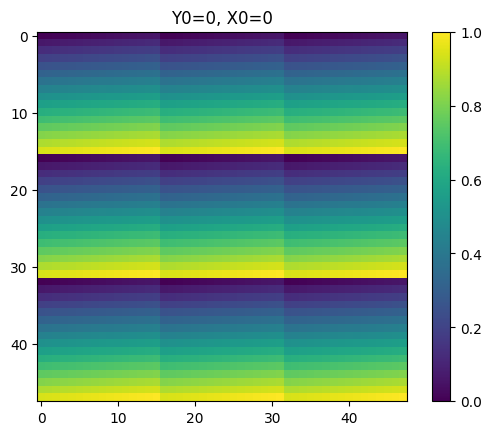

[min, max]  = [0.0, 1.0]


In [ ]:
for Y1 in Y1_range:
    Y2 = Y1+OUT_ROWS
    for X1 in X1_range:
        X2 = X1+OUT_COLS

        img_postcrop = img_precrop[Y1:Y2, X1:X2]
        img_postcrop_float = np.array([[bin_to_int(val) for val in row] for row in img_postcrop])

        max_val = np.max(img_postcrop_float)
        img_postnorm_float = (img_postcrop_float/max_val).astype(np.float64)
        img_postnorm = np.array([[frac_to_bin(val, n_bits=FP_TOTAL) for val in row] for row in img_postnorm_float])

        fpath_img_postnorm = os.path.join(top_level_dir, f"Y1_{Y1}", f"X1_{X1}", f"img_postnorm{DATA_STRING_INSERT}.txt")
        os.makedirs(os.path.dirname(fpath_img_postcrop_hex), exist_ok=True)
        with open(fpath_img_postnorm, "w") as f:
            for i, row in enumerate(img_postnorm):
                if i > 0:
                    f.write("\n")
                for val in row:
                    val_hex = str(hex(int(val,2))).replace("0x", "")
                    if len(val_hex) < 2:
                        new_val_hex = "0"*(2-len(val_hex))+val_hex
                        val_hex = new_val_hex
                    f.write(f"{val_hex} ")

        plt.figure()
        plt.imshow(img_postnorm_float)
        plt.colorbar()
        plt.title(f"Y0={Y1}, X0={X1}")
        plt.show()
        plt.close()
        print(f"[min, max]  = [{np.min(np.min(img_postnorm_float, axis=0), axis=0)}, {np.max(np.max(img_postnorm_float, axis=0), axis=0)}]")


# 4. 1D data for Verilog testbench
Yes, this is very annoying

HDL CropNorm Out 1D copy

In [8]:
for Y1 in Y1_range:
    Y2 = Y1+OUT_ROWS
    for X1 in X1_range:
        X2 = X1+OUT_COLS

        img_postcrop = img_precrop[Y1:Y2, X1:X2]
        img_postcrop_float = np.array([[bin_to_int(val) for val in row] for row in img_postcrop])

        max_val = np.max(img_postcrop_float)
        img_postnorm_float = (img_postcrop_float/max_val).astype(np.float64)
        img_postnorm = np.array([[frac_to_bin(val, n_bits=FP_TOTAL) for val in row] for row in img_postnorm_float])

        fpath_img_hdl_cropnorm = os.path.join(top_level_dir, f"Y1_{Y1}", f"X1_{X1}", f"HDL_cropnorm_out.txt")
        cropnorm_data = []
        with open(fpath_img_hdl_cropnorm, "r") as f:
            for line in f.read().split("\n"):
                cropnorm_data.append(line.split(" "))

        fpath_img_hdl_cropnorm_1d = os.path.join(top_level_dir, f"Y1_{Y1}", f"X1_{X1}", f"HDL_cropnorm_out_1D.txt")
        with open(fpath_img_hdl_cropnorm_1d, "w") as f:
            for line in cropnorm_data:
                for val in line:
                    f.write(f"{val}\n")